In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras

from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import cv2
import numpy as np

# Function to apply heatmap filter to an image
def apply_heatmap_filter(image):
    # Convert the BGR image to RGB
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Convert the RGB image to grayscale
    gray_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2GRAY)

    # Apply a colormap to the grayscale image
    heatmap_image = cv2.applyColorMap(gray_image, cv2.COLORMAP_JET)

    return heatmap_image

# Folder containing the dataset of images
folder = "/content/drive/MyDrive/NBGP/N-BGP Dataset/Complete"

# Lists to store processed images and labels
processed_images = []
labels = []

# Iterate through each image in the folder
for filename in os.listdir(folder):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        # Read the image
        image_path = os.path.join(folder, filename)
        img = cv2.imread(image_path)

        # Apply heatmap filter to the image
        heatmap_img = apply_heatmap_filter(img)

        # Append the processed image and its label
        processed_images.append(heatmap_img)
        label = filename.split("(")[0]
        labels.append(label)

# Convert lists to numpy arrays  # Transformer encoder stack

processed_images_array = np.array(processed_images)
labels_array = np.array(labels)

# Save the processed images and labpip install --upgrade tensorflow  # TensorFlow usually includes Kerasels
np.save("processed_images_data.npy", processed_images_array)
np.save("labels_data.npy", labels_array)


In [ ]:
processed_images_array.shape

(102, 562, 562, 3)

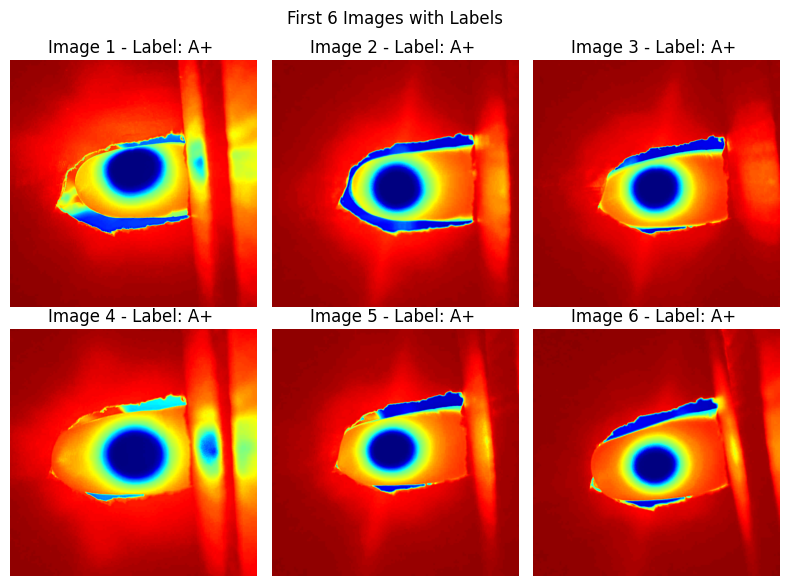

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(8, 6))

for i in range(6):
  image = processed_images[i]
  label = labels[i]
  axes[i // 3, i % 3].imshow(image)
  axes[i // 3, i % 3].set_title(f"Image {i+1} - Label: {label}")
  axes[i // 3, i % 3].axis("off")

fig.suptitle(f"First 6 Images with Labels", fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
images_array = processed_images_array.reshape(processed_images_array.shape[0], 562, 562, 3)
labels_array = labels_array.reshape(-1,1)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(handle_unknown='ignore')
ohe.fit(labels_array)
ohe.categories_

[array(['A+ ', 'A- ', 'AB+ ', 'B+ ', 'O+ ', 'O- '], dtype='<U4')]

In [ ]:
y = ohe.transform(labels_array)
y = y.toarray()
len(y)

102

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(processed_images_array, y, test_size=0.25, random_state=42)


In [ ]:
input_shape = X_train[0].shape
input_shape

(562, 562, 3)

In [ ]:
y_train[0]

array([0., 0., 1., 0., 0., 0.])

In [ ]:
resized_X_train = np.array([cv2.resize(img, (224, 224)) for img in X_train])
resized_X_test = np.array([cv2.resize(img, (224, 224)) for img in X_test])

In [ ]:
# from tensorflow.keras.applications import Alexnet
from keras.layers import GlobalAveragePooling2D, Dense
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Model

from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Model

def create_alexnet_model(input_shape=(224, 224, 3), num_classes=6):

  # Input layer
  inputs = keras.Input(shape=input_shape)

  # Block 1
  x = Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), activation='relu', padding='same')(inputs)
  x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

  # Block 2
  x = Conv2D(filters=256, kernel_size=(5, 5), padding='same', activation='relu')(x)
  x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

  # Block 3
  x = Conv2D(filters=384, kernel_size=(3, 3), padding='same', activation='relu')(x)

  # Block 4
  x = Conv2D(filters=384, kernel_size=(3, 3), padding='same', activation='relu')(x)

  # Block 5
  x = Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu')(x)
  x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

  # Flatten
  x = Flatten()(x)

  # Classification head
  x = Dense(4096, activation='relu')(x)
  x = Dropout(0.5)(x)  # Consider adjusting dropout rate
  x = Dense(4096, activation='relu')(x)
  x = Dropout(0.5)(x)  # Consider adjusting dropout rate
  predictions = Dense(num_classes, activation='softmax')(x)

  # Create the model
  model = Model(inputs=inputs, outputs=predictions)

  # Compile the model
  optimizer = Adam(learning_rate=0.0001)  # Consider hyperparameter tuning
  model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

  return model

optimizer = Adam(learning_rate=0.0001)  # Consider hyperparameter tuning
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(resized_X_train, y_train,
                    epochs=40,
                    batch_size=64,
                    validation_data=(resized_X_test, y_test),
                    callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(resized_X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


Epoch 1/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 8s/step - accuracy: 0.5244 - loss: 1.3115 - val_accuracy: 0.3462 - val_loss: 1.6545
Epoch 2/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 968ms/step - accuracy: 0.4178 - loss: 1.5025 - val_accuracy: 0.3462 - val_loss: 1.4640
Epoch 3/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 979ms/step - accuracy: 0.3898 - loss: 1.4618 - val_accuracy: 0.4231 - val_loss: 1.4218
Epoch 4/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.5000 - loss: 1.2807 - val_accuracy: 0.2692 - val_loss: 1.5030
Epoch 5/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.4668 - loss: 1.3440 - val_accuracy: 0.2692 - val_loss: 1.4953
Epoch 6/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.3462 - loss: 1.3016 - val_accuracy: 0.4231 - val_loss: 1.4489
Epoch 7/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.4825 - loss: 1.3329 - val_accuracy: 0.3462 - val_loss: 1.4729
Epoch 8/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.4405 - loss: 1.3272 - val_accuracy: 0.3462 - val_loss: 1.4480

In [ ]:
model.summary()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 56, 56, 96)          │          34,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 28, 28, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 28, 28, 256)         │         614,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 14, 14, 384)         │         885,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 14, 14, 384)         │       1,327,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 14, 14, 256)         │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 4096)                │      51,384,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 6)                   │          24,582 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 215,812,244 (823.26 MB)

 Trainable params: 71,937,414 (274.42 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 143,874,830 (548.84 MB)

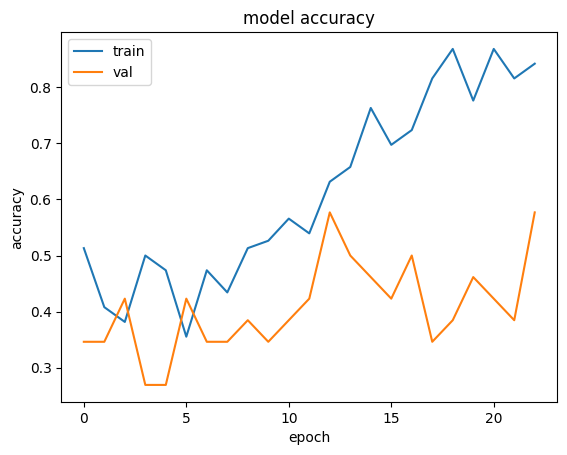

In [ ]:
plt.plot(history.history[ "accuracy" ])
plt.plot(history.history[ "val_accuracy" ])
plt.title( "model accuracy" )

plt.ylabel( "accuracy" )
plt.xlabel( "epoch" )
plt.legend([ "train" , "val" ], loc= "upper left" )
plt.show()

In [ ]:
y_pred = model.predict(resized_X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


In [ ]:
max_indices = np.argmax(y_pred, axis=1)
y_pred_one_hot = np.zeros_like(y_pred)
rows = np.arange(len(y_pred))
y_pred_one_hot[rows, max_indices] = 1

In [ ]:
y_pred = ohe.inverse_transform(y_pred_one_hot)
y_test = ohe.inverse_transform(y_test)

In [ ]:
from sklearn.metrics import accuracy_score
print("Accuracy: ", accuracy_score(y_test, y_pred))

Accuracy:  0.5769230769230769
